# Assignment 10 - Viraj Noorithaya


## Script Parameters


In [1]:
# Where are you running this? Can be either 'local' or 'colab'
model_run_location = "local"

# # Do you want to install the required packages?
# install_required_packages = False
install_required_packages = False if model_run_location == "local" else True

# git repository url
repo_name = "era-v1"
git_repo_url = "https://github.com/nviraj/era-v1.git"

# Is the model being developed or is it in production?
# Can be development or production
code_mode = "development"

# WHich branch are you working on?
branch_name = "week-10" if code_mode == "development" else "main"
folder_name = "Session 10/Submission"

## Library Installation (Optional)


In [2]:
# # Install any required libraries not present in your working environment

if install_required_packages:
    # # Needed locally and in colab
    # !pip install torchsummary
    # !conda install -c frgfm torchscan

    import sys
    # !{sys.executable} -m pip install torchsummary
    !{sys.executable} -m pip install torch-lr-finder
    !{sys.executable} -m pip install torchinfo

    # if model_run_location == 'colab':
    #     !{sys.executable} -m pip install albumentations

    # # Needed locally
    # !conda install -c conda-forge tqdm
    # !conda install -c anaconda ipywidgets

    if model_run_location == 'local':
        %conda install --yes --prefix {sys.prefix} -c conda-forge tqdm
        %conda install --yes --prefix {sys.prefix} -c anaconda ipywidgets
        %conda install --yes --prefix {sys.prefix} -c conda-forge imgaug
        %conda install --yes --prefix {sys.prefix} -c conda-forge albumentations


## Code Procurement


In [3]:
# Mount google drive if running on colab
if model_run_location == 'colab':
    # from google.colab import drive
    # drive.mount('/content/drive')
    # %cd /content/drive/MyDrive/WorkSpace/era-v1/Session 10/Submission

    # Delete the folder if it exists
    # Avoids fatal: destination path already exists and is not an empty directory.
    # Get code from github
    !rm -rf {repo_name} && git clone {git_repo_url}

    # Switch to repo folder, Needed to switch branch
    # Switch branch and change to the correct directory
    !cd "{repo_name}" && git checkout {branch_name} && cd "{folder_name}"

## Import Libraries


In [4]:
# Import necessary modules (external libs)
import os

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch_lr_finder import LRFinder

# from torchsummary import summary

d:\Apps\Anaconda3\envs\era-v1\Lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
import sys

print(f"CWD: {os.getcwd()}")

if model_run_location == "colab":
    print(f"Appending folder to path in order to detect modules: {folder_name}")
    sys.path.append(f"era-v1/{folder_name}")

CWD: d:\Root\Personal\WorkSpace\era-v1\Session 10\Submission


In [6]:
# Import user defined modules
from modules.dataset import split_cifar_data, apply_cifar_image_transformations
from modules.dataset import CIFAR_MEAN, CIFAR_STD, CIFAR_CLASSES
from modules.custom_resnet import CustomResNet as Net
from modules.custom_resnet import detailed_model_summary
from modules.trainer import train_and_test_model
from modules.utils import get_device, save_model, pretty_print_metrics
from modules.visualize import (
    plot_misclassified_images,
    plot_sample_training_images,
    plot_train_test_metrics,
)

## Script Parameters


In [7]:
# Constants naming convention: All caps separated by underscore
# https://realpython.com/python-constants/

# Specify the number of epochs
NUM_EPOCHS = 24

# Set the batch size
BATCH_SIZE = 512

# What is the start LR and weight decay you'd prefer?
PREFERRED_START_LR = 0.3
PREFERRED_WEIGHT_DECAY = 1E-4

# Set seed value for reproducibility
SEED = 123

# Expected accuracy
TARGET_ACCURACY = 90.0

## Get Device


In [8]:
# Functionality to check cuda support and create device is now moved to utils.py
device_support, device = get_device()
print(f"Device created with {device_support}!")

Device created with cuda!


### Reproducibility settings


In [9]:
# For reproducibility
# https://pytorch.org/docs/stable/notes/randomness.html
# https://github.com/pytorch/pytorch/issues/7068
import random
import numpy as np

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

if device_support == "cuda":
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)


# To be passed to dataloader
def _init_fn(worker_id):
    np.random.seed(int(SEED))

## Data Transformations


In [10]:
# Train and test data transformation steps now moved to apply_mnist_image_transformations()

# cutout needs to be half of the image size
cutout_size = 8

train_transforms, test_transforms = apply_cifar_image_transformations(
    mean=CIFAR_MEAN, std=CIFAR_STD, cutout_size=cutout_size
)

## Train/Test Split


In [11]:
data_path = "../../data"
print(f"Train and test data path: {data_path}")

train_data, test_data = split_cifar_data(data_path, train_transforms, test_transforms)

Train and test data path: ../../data

Files already downloaded and verified
Files already downloaded and verified

Mean: [0.4914009  0.48215896 0.4465308 ]
Std: [0.24703279 0.24348423 0.26158753]

Transforms applied on the dataset



## Dataloaders


In [12]:
# calculate the number of workers
num_workers = (os.cpu_count() - 1) if os.cpu_count() > 3 else 2
# If run_mode is local, use only 2 workers
num_workers = num_workers if model_run_location == "colab" else 0
print(f"Number of workers: {num_workers}")

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=num_workers,
    pin_memory=True,
    worker_init_fn=_init_fn,
)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

Number of workers: 0


In [13]:
# Get class mapping for the dataset
classes = CIFAR_CLASSES
print(classes)

('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')


## Sample Training Images


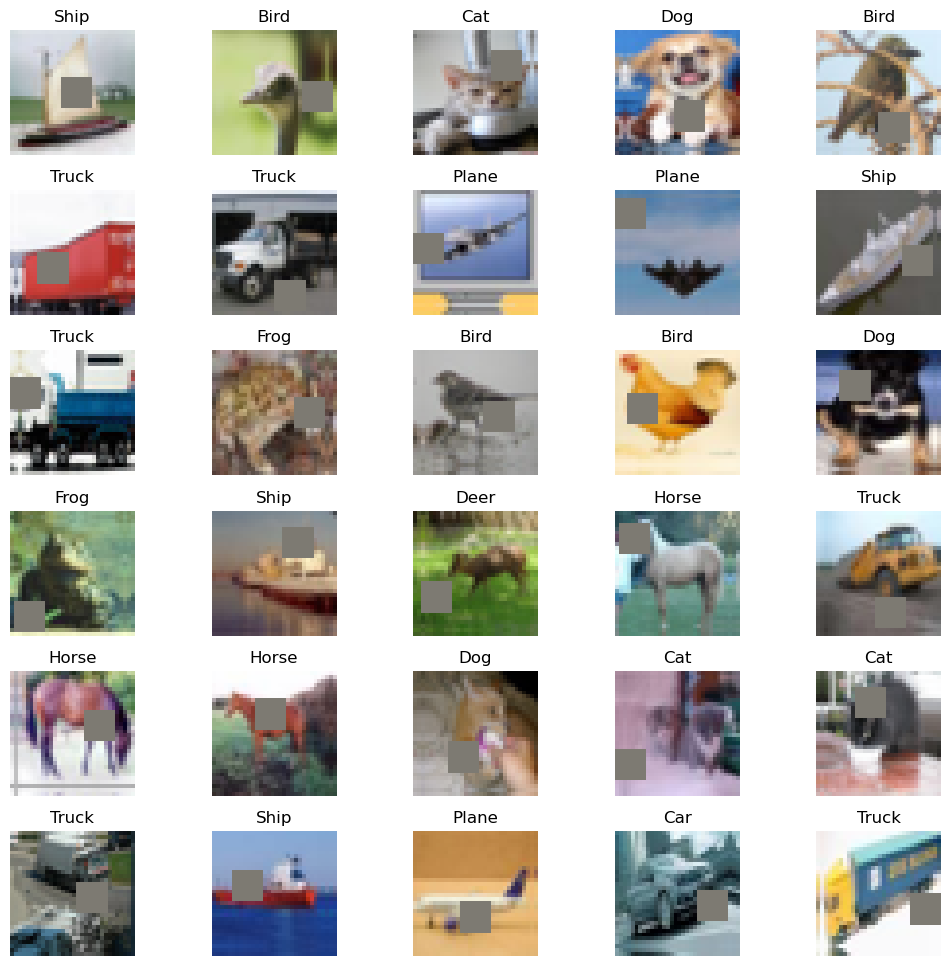

In [14]:
# Get a batch of training data from train_loader
batch_data, batch_label = next(iter(train_loader))

# Plot 30 sample images from the training data along with their labels
# plot_sample_training_images() imported from utils.py
fig, axs = plot_sample_training_images(
    batch_data, batch_label, class_label=classes, num_images=30
)
plt.show()

## Model Summary


In [15]:
# Model class is imported from model.py

# Send the model to device
model = Net().to(device)

# enable printing shape
model.print_shape = True

# # Print the model summary by specifying the input size
# summary(model, input_size=(3, 32, 32))
detailed_model_summary(model, input_size=(3, 32, 32), device=device)

# disable printing shape for cleaner test train output
model.print_shape = False

PrepLayer 
	 torch.Size([1, 64, 32, 32]) 

Layer 1, X 
	 torch.Size([1, 128, 16, 16]) 

Layer 1, R1 
	 torch.Size([1, 128, 16, 16]) 

Layer 1, X + R1 
	 torch.Size([1, 128, 16, 16]) 

Layer 2 
	 torch.Size([1, 256, 8, 8]) 

Layer 3, X 
	 torch.Size([1, 512, 4, 4]) 

Layer 3, R2 
	 torch.Size([1, 512, 4, 4]) 

Layer 3, X + R2 
	 torch.Size([1, 512, 4, 4]) 

Max Pooling 
	 torch.Size([1, 512, 1, 1]) 

Reshape before FC 
	 torch.Size([1, 512]) 

After FC 
	 torch.Size([1, 10]) 

Layer (type:depth-idx)                   Input Shape      Kernel Shape     Output Shape     Param #          Trainable
CustomResNet                             [1, 3, 32, 32]   --               [1, 10]          --               True
├─Sequential: 1-1                        [1, 3, 32, 32]   --               [1, 64, 32, 32]  --               True
│    └─Conv2d: 2-1                       [1, 3, 32, 32]   [3, 3]           [1, 64, 32, 32]  1,728            True
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]  

## Train and Test


### Optimizer and Loss Function


In [16]:
# Create optimizer and scheduler
# Use ADAM
# https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
optimizer = optim.Adam(
    model.parameters(), lr=PREFERRED_START_LR, weight_decay=PREFERRED_WEIGHT_DECAY
)

# Define criteria function
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion = torch.nn.CrossEntropyLoss()

### Find Learning Rate


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.11E-01


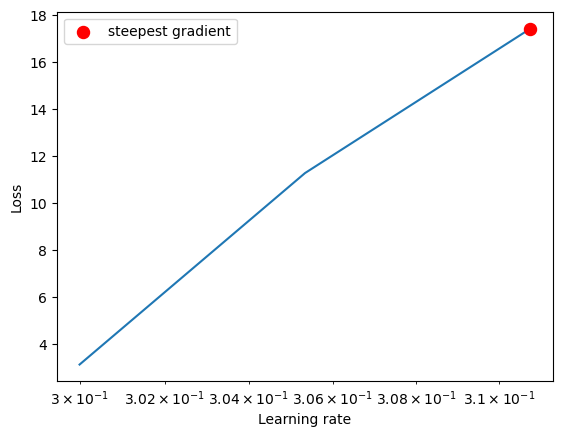

In [17]:
# Use LR Finder to find the best starting learning rate
# https://github.com/davidtvs/pytorch-lr-finder
# https://github.com/davidtvs/pytorch-lr-finder#notes
# https://github.com/davidtvs/pytorch-lr-finder/blob/master/torch_lr_finder/lr_finder.py

# Create LR finder object
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(
    train_loader=train_loader, end_lr=10, num_iter=100, step_mode="exp"
)
# https://github.com/davidtvs/pytorch-lr-finder/issues/88
plot, suggested_lr = lr_finder.plot(suggest_lr=True, skip_start=0, skip_end=0)
lr_finder.reset()
# plot.figure.savefig("LRFinder - Suggested Max LR.png")

### Scheduler


In [18]:
# # Learning rate scheduler based on plateau
# # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
# scheduler = ReduceLROnPlateau(
#     optimizer, mode="min", factor=0.5, patience=1, threshold=0.03, verbose=False
# )

print(f"Suggested Max LR: {suggested_lr}")

# Learning rate scheduler based on OneCycleLR
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html
scheduler = OneCycleLR(
    optimizer,
    max_lr=suggested_lr,
    steps_per_epoch=len(train_loader),
    epochs=NUM_EPOCHS,
    pct_start=5 / NUM_EPOCHS,
    div_factor=100,
    three_phase=False,
    anneal_strategy="linear",
    final_div_factor=100,
    verbose=False,
)

Suggested Max LR: 0.3107610418205271


### Train and test model


In [19]:
# Create a dictionary of lists for misclassified images, generated predictions and ground truth
misclassified_image_data = {"images": [], "ground_truths": [], "predicted_vals": []}

# Run the model for NUM_EPOCHS
results = train_and_test_model(
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    model=model,
    device=device,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    misclassified_image_data=misclassified_image_data,
)



Batch size: 512, Total epochs: 24


Epoch 1


Train: Loss=1.5383, Batch_id=97, Accuracy=31.74: 100%|██████████| 98/98 [00:36<00:00,  2.69it/s]


Test set: Average loss: 0.0030,  Accuracy: 4530/10000  (45.30%)


Epoch 2


Train: Loss=1.0947, Batch_id=97, Accuracy=53.15: 100%|██████████| 98/98 [00:35<00:00,  2.77it/s]


Test set: Average loss: 0.0022,  Accuracy: 6067/10000  (60.67%)


Epoch 3


Train: Loss=0.8200, Batch_id=97, Accuracy=65.05: 100%|██████████| 98/98 [00:35<00:00,  2.73it/s]


Test set: Average loss: 0.0020,  Accuracy: 6541/10000  (65.41%)


Epoch 4


Train: Loss=0.7283, Batch_id=97, Accuracy=71.74: 100%|██████████| 98/98 [00:35<00:00,  2.74it/s]


Test set: Average loss: 0.0016,  Accuracy: 7349/10000  (73.49%)


Epoch 5


Train: Loss=0.7451, Batch_id=97, Accuracy=76.96: 100%|██████████| 98/98 [00:35<00:00,  2.74it/s]


Test set: Average loss: 0.0013,  Accuracy: 7792/10000  (77.92%)


Epoch 6


Train: Loss=0.5189, Batch_id=97, Accuracy=79.09: 100%|██████████| 98/98 [00:35<00:00,  2.75it/s]


Test set: Average loss: 0.0011,  Accuracy: 8048/10000  (80.48%)


Epoch 7


Train: Loss=0.4990, Batch_id=97, Accuracy=81.61: 100%|██████████| 98/98 [00:35<00:00,  2.78it/s]


Test set: Average loss: 0.0011,  Accuracy: 8238/10000  (82.38%)


Epoch 8


Train: Loss=0.5390, Batch_id=97, Accuracy=83.46: 100%|██████████| 98/98 [00:35<00:00,  2.74it/s]


Test set: Average loss: 0.0009,  Accuracy: 8408/10000  (84.08%)


Epoch 9


Train: Loss=0.3816, Batch_id=97, Accuracy=84.63: 100%|██████████| 98/98 [00:35<00:00,  2.74it/s]


Test set: Average loss: 0.0010,  Accuracy: 8383/10000  (83.83%)


Epoch 10


Train: Loss=0.5163, Batch_id=97, Accuracy=85.60: 100%|██████████| 98/98 [00:35<00:00,  2.79it/s]


Test set: Average loss: 0.0011,  Accuracy: 8271/10000  (82.71%)


Epoch 11


Train: Loss=0.3728, Batch_id=97, Accuracy=86.70: 100%|██████████| 98/98 [00:34<00:00,  2.81it/s]


Test set: Average loss: 0.0008,  Accuracy: 8650/10000  (86.50%)


Epoch 12


Train: Loss=0.3399, Batch_id=97, Accuracy=87.53: 100%|██████████| 98/98 [00:35<00:00,  2.78it/s]


Test set: Average loss: 0.0008,  Accuracy: 8695/10000  (86.95%)


Epoch 13


Train: Loss=0.4519, Batch_id=97, Accuracy=88.19: 100%|██████████| 98/98 [00:34<00:00,  2.81it/s]


Test set: Average loss: 0.0009,  Accuracy: 8643/10000  (86.43%)


Epoch 14


Train: Loss=0.2999, Batch_id=97, Accuracy=88.01: 100%|██████████| 98/98 [00:35<00:00,  2.74it/s]


Test set: Average loss: 0.0008,  Accuracy: 8753/10000  (87.53%)


Epoch 15


Train: Loss=0.2929, Batch_id=97, Accuracy=89.33: 100%|██████████| 98/98 [00:35<00:00,  2.79it/s]


Test set: Average loss: 0.0008,  Accuracy: 8728/10000  (87.28%)


Epoch 16


Train: Loss=0.2233, Batch_id=97, Accuracy=90.10: 100%|██████████| 98/98 [00:34<00:00,  2.80it/s]


Test set: Average loss: 0.0008,  Accuracy: 8773/10000  (87.73%)


Epoch 17


Train: Loss=0.2889, Batch_id=97, Accuracy=90.83: 100%|██████████| 98/98 [00:36<00:00,  2.71it/s]


Test set: Average loss: 0.0007,  Accuracy: 8880/10000  (88.80%)


Epoch 18


Train: Loss=0.2131, Batch_id=97, Accuracy=91.09: 100%|██████████| 98/98 [00:35<00:00,  2.79it/s]


Test set: Average loss: 0.0009,  Accuracy: 8641/10000  (86.41%)


Epoch 19


Train: Loss=0.2899, Batch_id=97, Accuracy=91.17: 100%|██████████| 98/98 [00:35<00:00,  2.78it/s]


Test set: Average loss: 0.0007,  Accuracy: 8863/10000  (88.63%)


Epoch 20


Train: Loss=0.2041, Batch_id=97, Accuracy=91.66: 100%|██████████| 98/98 [00:34<00:00,  2.81it/s]


Test set: Average loss: 0.0007,  Accuracy: 8892/10000  (88.92%)


Epoch 21


Train: Loss=0.2006, Batch_id=97, Accuracy=92.09: 100%|██████████| 98/98 [00:35<00:00,  2.75it/s]


Test set: Average loss: 0.0008,  Accuracy: 8873/10000  (88.73%)


Epoch 22


Train: Loss=0.2075, Batch_id=97, Accuracy=91.86: 100%|██████████| 98/98 [00:35<00:00,  2.75it/s]


Test set: Average loss: 0.0008,  Accuracy: 8751/10000  (87.51%)


Epoch 23


Train: Loss=0.2473, Batch_id=97, Accuracy=92.20: 100%|██████████| 98/98 [00:34<00:00,  2.82it/s]


Test set: Average loss: 0.0008,  Accuracy: 8921/10000  (89.21%)


Epoch 24


Train: Loss=0.2570, Batch_id=97, Accuracy=92.43: 100%|██████████| 98/98 [00:35<00:00,  2.75it/s]


Test set: Average loss: 0.0007,  Accuracy: 8853/10000  (88.53%)




In [20]:
# Pretty print train and test accuracy and loss values for each epoch
pretty_print_metrics(num_epochs=NUM_EPOCHS, results=results)

Epoch: 01, Train Loss: 2.0141, Test Loss: 0.0030, Train Accuracy: 31.7400, Test Accuracy: 45.3000
Epoch: 02, Train Loss: 1.2964, Test Loss: 0.0022, Train Accuracy: 53.1460, Test Accuracy: 60.6700
Epoch: 03, Train Loss: 0.9847, Test Loss: 0.0020, Train Accuracy: 65.0520, Test Accuracy: 65.4100
Epoch: 04, Train Loss: 0.8052, Test Loss: 0.0016, Train Accuracy: 71.7420, Test Accuracy: 73.4900
Epoch: 05, Train Loss: 0.6642, Test Loss: 0.0013, Train Accuracy: 76.9640, Test Accuracy: 77.9200
Epoch: 06, Train Loss: 0.6056, Test Loss: 0.0011, Train Accuracy: 79.0920, Test Accuracy: 80.4800
Epoch: 07, Train Loss: 0.5331, Test Loss: 0.0011, Train Accuracy: 81.6140, Test Accuracy: 82.3800
Epoch: 08, Train Loss: 0.4806, Test Loss: 0.0009, Train Accuracy: 83.4600, Test Accuracy: 84.0800
Epoch: 09, Train Loss: 0.4433, Test Loss: 0.0010, Train Accuracy: 84.6280, Test Accuracy: 83.8300
Epoch: 10, Train Loss: 0.4138, Test Loss: 0.0011, Train Accuracy: 85.6020, Test Accuracy: 82.7100
Epoch: 11, Train Los

## Metrics


Expected accuracy: 90.0%
Plotting accuracy and loss graphs.


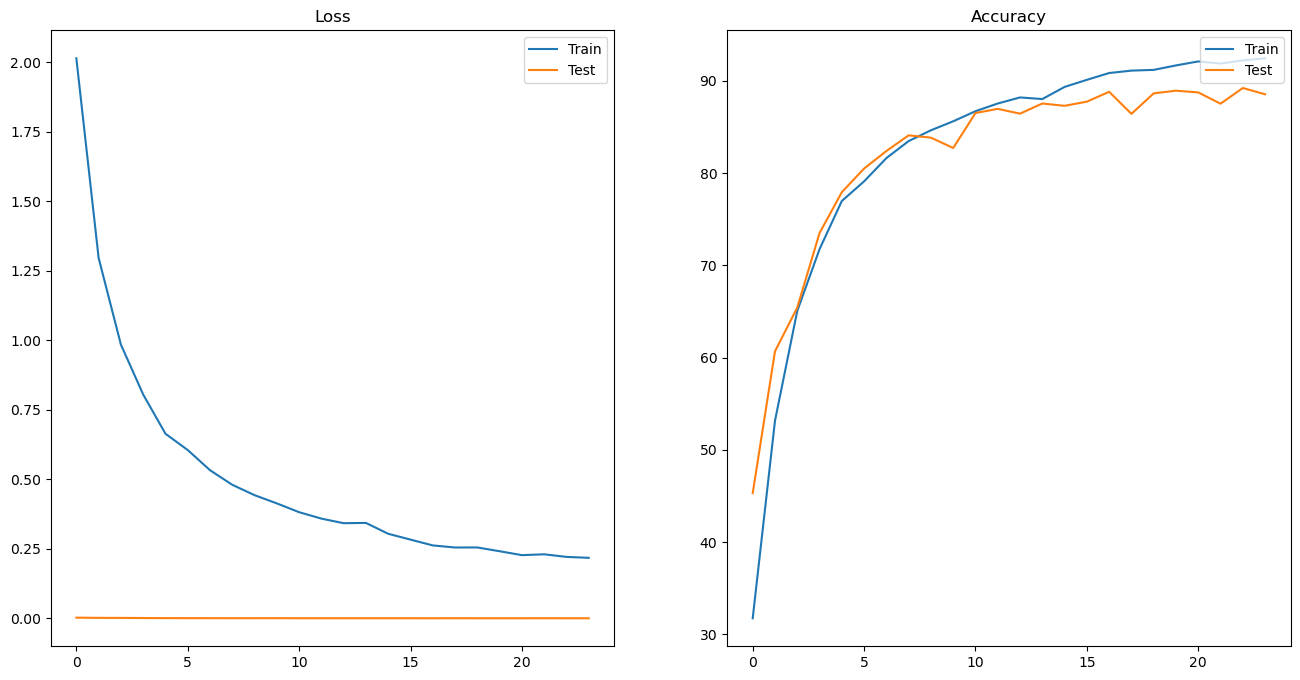

In [21]:
# Print expected accuracy for easier reference
print(f"Expected accuracy: {TARGET_ACCURACY}%")

# Plot the accuracy and loss graphs using data and plot_train_test_metrics() from model.py
print("Plotting accuracy and loss graphs.")
fig, axs = plot_train_test_metrics(results)
plt.show()
# plt.savefig("Loss and Accuracy Metrics.png")

## Save model


In [22]:
# Save model
print("Saving the model as the training is complete!")
save_model(
    epoch=NUM_EPOCHS,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    batch_size=BATCH_SIZE,
    criterion=criterion,
    file_name="model_last_epoch.pth",
)

Saving the model as the training is complete!


## Show incorrect images


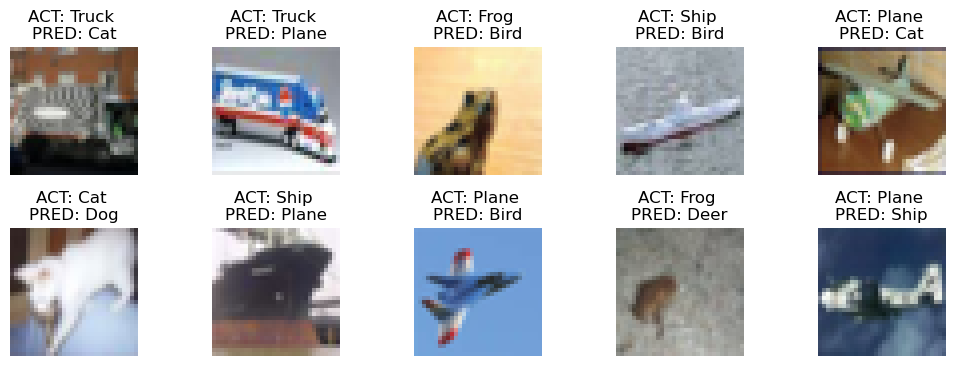

In [23]:
# Plot misclassified images
fig, axs = plot_misclassified_images(
    data=misclassified_image_data, class_label=classes, num_images=10
)
plt.show()
# plt.savefig("Misclassified Images.png")